In [46]:
%matplotlib inline
import os
import pandas as pd
from fbprophet import Prophet
import json
from datetime import datetime, timedelta

In [22]:
def get_datetime_from_string(s, keep_utc=True):
    if keep_utc:
        return datetime.strptime(s + "00", '%Y-%m-%d %H:%M:%S%z')
    else:
        return datetime.strptime(s[:-3], '%Y-%m-%d %H:%M:%S')

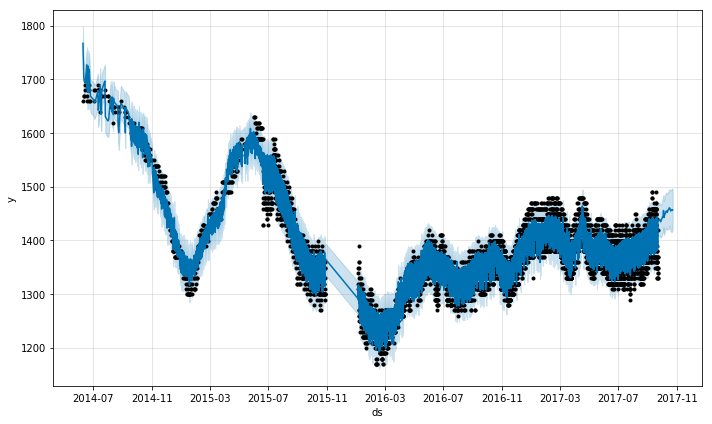

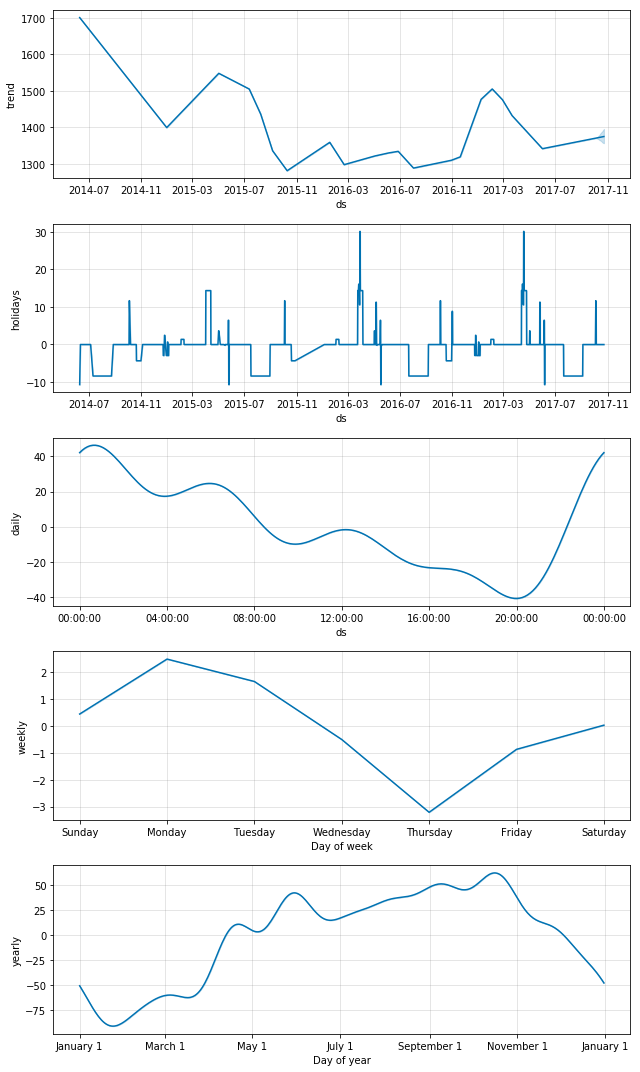

In [136]:
def predict_for_gas_station(gas_station_id, days=31):
    GAS_STATIONS_PATH = os.path.join('..', 'data', 'processed', 'Tankstellen_states.csv')
    GAS_PRICE_PATH = os.path.join('..', 'data', 'raw', 'input_data', 'Eingabedaten', 'Benzinpreise')
    GAS_STATION_PATH = os.path.join(GAS_PRICE_PATH, "{}.csv".format(gas_station_id))
    
    gas_stations_df = pd.read_csv(GAS_STATIONS_PATH, sep=',')
    gas_station_state = gas_stations_df[gas_stations_df["id"] == gas_station_id]["State"].iloc[0]

    df_gas_station = pd.read_csv(GAS_STATION_1_PATH, names=['Timestamp', 'Price'], sep=';')
    df_gas_station.head()
    
    holidays_path = os.path.join('..', 'data', 'processed', "holidays_{}.csv".format(str(gas_station_state)))
    df_holidays = pd.read_csv(holidays_path)
    df_vacations = pd.read_csv(os.path.join('..', 'data', 'processed', "vacations_{}.csv".format(gas_station_state)))
    
    holidays_df = pd.concat((df_holidays, df_vacations))
    m = Prophet(holidays=holidays_df)
    df_fb = df_gas_station.copy()
    df_fb['y'] = df_fb['Price']
    df_fb['ds'] = df_fb['Timestamp'].apply(lambda x : get_datetime_from_string(str(x), keep_utc=False))
    df_fb.drop(['Timestamp', 'Price'], inplace=True, axis=1)
    m.fit(df_fb)
    future = m.make_future_dataframe(periods=days)
    forecast = m.predict(future)
    m.plot(forecast);
    m.plot_components(forecast);
    return m, future, forecast
    
predict_for_gas_station(1905)

In [146]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,1. Weihnachtstag,1. Weihnachtstag_lower,1. Weihnachtstag_upper,2. Weihnachtstag,2. Weihnachtstag_lower,2. Weihnachtstag_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,Herbstferien,Herbstferien_lower,Herbstferien_upper,Karfreitag,Karfreitag_lower,Karfreitag_upper,Neujahrstag,Neujahrstag_lower,Neujahrstag_upper,Osterferien,Osterferien_lower,Osterferien_upper,Ostermontag,Ostermontag_lower,Ostermontag_upper,Pfingstferien,Pfingstferien_lower,Pfingstferien_upper,Pfingstmontag,Pfingstmontag_lower,Pfingstmontag_upper,Reformationstag,Reformationstag_lower,Reformationstag_upper,Sommerferien,Sommerferien_lower,Sommerferien_upper,Tag der Arbeit,Tag der Arbeit_lower,Tag der Arbeit_upper,Tag der Deutschen Einheit,Tag der Deutschen Einheit_lower,Tag der Deutschen Einheit_upper,Weihnachtsferien,Weihnachtsferien_lower,Weihnachtsferien_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-06-09 00:02:01,1696.941314,1696.941314,1696.941314,1738.089142,1796.587311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.666307,-10.666307,-10.666307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.589200,42.589200,42.589200,-10.666307,-10.666307,-10.666307,70.075660,70.075660,70.075660,80.741967,80.741967,80.741967,2.908315,2.908315,2.908315,35.244452,35.244452,35.244452,1767.016974
1,2014-06-10 17:14:01,1694.458839,1694.458839,1694.458839,1670.745338,1733.235690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.592081,-24.592081,-24.592081,0.000000,0.000000,0.000000,7.912929,7.912929,7.912929,7.912929,7.912929,7.912929,0.371866,0.371866,0.371866,32.133144,32.133144,32.133144,1702.371767
2,2014-06-11 17:14:01,1693.012737,1693.012737,1693.012737,1665.430243,1726.684541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.592081,-24.592081,-24.592081,0.000000,0.000000,0.000000,3.134659,3.134659,3.134659,3.134659,3.134659,3.134659,-2.597248,-2.597248,-2.597248,30.323988,30.323988,30.323988,1696.147396
3,2014-06-12 17:14:01,1691.566635,1691.566635,1691.566635,1665.156627,1726.796955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.592081,-24.592081,-24.592081,0.000000,0.000000,0.000000,1.980833,1.980833,1.980833,1.980833,1.980833,1.980833,-1.984571,-1.984571,-1.984571,28.557485,28.557485,28.557485,1693.547468
4,2014-06-13 17:14:01,1690.120533,1690.120533,1690.120533,1662.723567,1720.530155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.592081,-24.592081,-24.592081,0.000000,0.000000,0.000000,2.044633,2.044633,2.044633,2.044633,2.044633,2.044633,-0.226692,-0.226692,-0.226692,26.863405,26.863405,26.863405,1692.165165


In [158]:
forecast2 = forecast.drop(["ds", "trend", "trend_lower", "trend_upper", "yhat_lower", "yhat_upper", "daily", "daily_lower", "daily_upper", "holidays", "holidays_lower", "holidays_upper", "seasonal", "seasonal_lower", "seasonal_upper", "seasonalities", "seasonalities_lower", "seasonalities_upper", "weekly", "weekly_lower", "weekly_upper", "yearly", "yearly_lower", "yearly_upper", "yhat"], axis=1)
forecast.iloc[list(forecast2.idxmax()), :]

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,1. Weihnachtstag,1. Weihnachtstag_lower,1. Weihnachtstag_upper,2. Weihnachtstag,2. Weihnachtstag_lower,2. Weihnachtstag_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,Herbstferien,Herbstferien_lower,Herbstferien_upper,Karfreitag,Karfreitag_lower,Karfreitag_upper,Neujahrstag,Neujahrstag_lower,Neujahrstag_upper,Osterferien,Osterferien_lower,Osterferien_upper,Ostermontag,Ostermontag_lower,Ostermontag_upper,Pfingstferien,Pfingstferien_lower,Pfingstferien_upper,Pfingstmontag,Pfingstmontag_lower,Pfingstmontag_upper,Reformationstag,Reformationstag_lower,Reformationstag_upper,Sommerferien,Sommerferien_lower,Sommerferien_upper,Tag der Arbeit,Tag der Arbeit_lower,Tag der Arbeit_upper,Tag der Deutschen Einheit,Tag der Deutschen Einheit_lower,Tag der Deutschen Einheit_upper,Weihnachtsferien,Weihnachtsferien_lower,Weihnachtsferien_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
207,2014-12-25 08:42:01,1408.644804,1408.644804,1408.644804,1338.930626,1399.267081,2.285239,2.285239,2.285239,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.278178,7.278178,7.278178,-3.295358,-3.295358,-3.295358,9.563417,9.563417,9.563417,-40.574535,-40.574535,-40.574535,-50.137952,-50.137952,-50.137952,-2.874971,-2.874971,-2.874971,-43.967623,-43.967623,-43.967623,1368.070269
207,2014-12-25 08:42:01,1408.644804,1408.644804,1408.644804,1338.930626,1399.267081,2.285239,2.285239,2.285239,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.278178,7.278178,7.278178,-3.295358,-3.295358,-3.295358,9.563417,9.563417,9.563417,-40.574535,-40.574535,-40.574535,-50.137952,-50.137952,-50.137952,-2.874971,-2.874971,-2.874971,-43.967623,-43.967623,-43.967623,1368.070269
207,2014-12-25 08:42:01,1408.644804,1408.644804,1408.644804,1338.930626,1399.267081,2.285239,2.285239,2.285239,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.278178,7.278178,7.278178,-3.295358,-3.295358,-3.295358,9.563417,9.563417,9.563417,-40.574535,-40.574535,-40.574535,-50.137952,-50.137952,-50.137952,-2.874971,-2.874971,-2.874971,-43.967623,-43.967623,-43.967623,1368.070269
0,2014-06-09 00:02:01,1696.941314,1696.941314,1696.941314,1738.089142,1796.587311,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.666307,-10.666307,-10.666307,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.589200,42.589200,42.589200,-10.666307,-10.666307,-10.666307,70.075660,70.075660,70.075660,80.741967,80.741967,80.741967,2.908315,2.908315,2.908315,35.244452,35.244452,35.244452,1767.016974
0,2014-06-09 00:02:01,1696.941314,1696.941314,1696.941314,1738.089142,1796.587311,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.666307,-10.666307,-10.666307,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000